
# Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.

In [1]:
!pip install albumentations==0.4.6

In [2]:
import torch
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from functools import partial
%matplotlib inline

cv = partial(nn.Conv2d, bias=False)
bn = nn.BatchNorm2d
relu = nn.ReLU

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [4]:
transform = transforms.Compose([transforms.ToTensor()]) # simple ToTensor for now

train_set = torchvision.datasets.CIFAR10(root='./cifar10', download=True, train=True, transform=transform)


Files already downloaded and verified


In [5]:
train_set.data.shape # train data shape

(50000, 32, 32, 3)

In [6]:
# calculate mean and standard deviation

m = np.mean(train_set.data, axis=(0,1,2))
print(m/255)

s = np.std(train_set.data, axis=(0, 1, 2))
print(s/255)

[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


In [7]:
mean = m/255
sdev = s/255

In [8]:
SEED = 101
BATCH = 32

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

if cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if cuda else "cpu")

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=BATCH, num_workers=2, pin_memory=True)\
    if cuda else dict(shuffle=True, batch_size=32)


CUDA Available? True


In [9]:
# # transforms
# train_transforms = transforms.Compose([transforms.ToTensor(),
#                                        transforms.Normalize(mean=mean, std=sdev)
#                                        ])

# test_transforms = transforms.Compose([transforms.ToTensor(),
#                                       transforms.Normalize(mean=mean, std=sdev)])

# # data sets with transforms
# train_set = torchvision.datasets.CIFAR10(root='./cifar-10', download=True, train=True, transform=train_transforms)

# test_set = torchvision.datasets.CIFAR10('./cifar-10', train=False, download=True, transform=test_transforms)


# # data loaders on data sets
# train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

# test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

# from __future__ import print_function
# channel_means = (0.49139968, 0.48215841, 0.44653091)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
# def unnormalize(img):
#   img = img.numpy().astype(dtype=np.float32)
  
#   for i in range(img.shape[0]):
#     img[i] = (img[i]*channel_stdevs[i])+channel_means[i]
  
#   return np.transpose(img, (1,2,0))
#   #return np.transpose(img, (1, 2, 0))

# %matplotlib inline
# import matplotlib.pyplot as plt
# dataiter = iter(train_loader)
# images, labels = dataiter.next()

# print(images.shape)
# print(labels.shape)

# num_classes = 10
# # display 10 images from each category. 
# class_names = ['airplane','automobile','bird','cat','deer',
#                'dog','frog','horse','ship','truck']
# r, c = 10, 11
# n = 5
# fig = plt.figure(figsize=(10,10))
# fig.subplots_adjust(hspace=0.04, wspace=0.04)
# for i in range(num_classes):
#     idx = np.random.choice(np.where(labels[:]==i)[0], n)
#     ax = plt.subplot(r, c, i*c+1)
#     ax.text(-1.5, 0.5, class_names[i], fontsize=14)
#     plt.axis('off')
#     for j in range(1, n+1):
#       plt.subplot(r, c, i*c+j+1)
#       plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
#       plt.axis('off')
# plt.show()

In [10]:
def train_eval_model(model, train_loader, optimizer, device, epochs=1, test=False, test_loader=None, scheduler=None):
          
    model.train() # set the train mode
    
    # iterate over for `epochs` epochs and keep storing valuable info

    for epoch in range(epochs):
      correct = processed = train_loss = 0
    #   if scheduler:
    #     scheduler.step()

      print(f"\n epoch num ================================= {epoch+1}")
      
      pbar = tqdm(train_loader)
      
      for batch_idx, (data, target) in enumerate(pbar):
          data, target = data.to(device), target.to(device) # move data to `device`

          optimizer.zero_grad() # zero out the gradients to avoid accumulating them over loops

          output = model(data) # get the model's predictions

          loss = F.nll_loss(output, target) # calculate Negative Log Likelihood loss using ground truth labels and the model's predictions

          train_loss += loss.item() # add up the train loss

          loss.backward() # boom ! The magic function to perform backpropagation and calculate the gradients

          optimizer.step() # take 1 step for the optimizer and update the weights

          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

          correct += pred.eq(target.view_as(pred)).sum().item() #  compare and see how many predictions are coorect and then add up the count

          processed += len(data) # total processed data size

      acc = 100 * correct/processed

      train_losses.append(train_loss)

      train_accuracy.append(acc)

      if scheduler:
        print("\n\n\t\t\tLast LR -->", scheduler.get_last_lr())
        scheduler.step()

      pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
      
      
      train_loss /= len(train_loader.dataset)
      print('\n\t\t\tTrain metrics: accuracy: {}/{} ({:.4f}%)'.format(correct,
                                                              len(train_loader.dataset),
                                                              correct * 100 / len(train_loader.dataset)))

      if test: # moving to evaluation
          model.eval() # set the correct mode
          
          correct = test_loss = 0

          with torch.no_grad(): # to disable gradient calculation with no_grad context
              
              for data, target in test_loader:

                  data, target = data.to(device), target.to(device)
                  
                  output = model(data)
                  
                  test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                  
                  pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                  
                  correct += pred.eq(target.view_as(pred)).sum().item()

          test_loss /= len(test_loader.dataset)
          test_losses.append(test_loss)
          test_accuracy.append(100. * correct / len(test_loader.dataset))

          print('\n\tTest metrics: average loss: {:.4f}, accuracy: {}/{} ({:.5f}%)\n'.format(
              test_loss, correct, len(test_loader.dataset),
              100. * correct / len(test_loader.dataset)))

In [11]:
def plot_graphs(*, train_losses, train_accuracy, test_losses, test_accuracy):
    fig, axs = plt.subplots(2,2,figsize=(20,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_accuracy)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_accuracy)
    axs[1, 1].set_title("Test Accuracy")

In [12]:
class Cifar10SearchDataset(torchvision.datasets.CIFAR10):
    def __init__(self, root="./data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [13]:
# transforms

# here changed CoarseDropout's p to 0.25 from default 0.5, along with minor change in MedianBlur value and HSV' value
train_transforms = A.Compose([
                                A.HorizontalFlip(p=0.2),
                                A.ShiftScaleRotate(shift_limit=0.1,scale_limit=0.15,rotate_limit=30,p=0.20),
                                A.CoarseDropout(max_holes=1, p=0.15, max_height=16,
                                                max_width=16, min_holes=1, min_height=16,
                                                min_width=16, fill_value=mean),
                                # A.MedianBlur(blur_limit=3, p=0.1),
                                A.HueSaturationValue(p=0.1),
                            #   A.GaussianBlur(blur_limit=3, p=0.12),
                                # A.RandomBrightnessContrast(brightness_limit=0.09,contrast_limit=0.1, p=0.15),   
                                A.Normalize(mean=mean, std=sdev),
                                ToTensor()
                                       ])

test_transforms = A.Compose([
                            A.Normalize(mean=mean, std=sdev),
                            ToTensor()
                                    ])


In [14]:

# data sets with transforms
train_set = Cifar10SearchDataset(train=True, download=True, transform=train_transforms)

test_set = Cifar10SearchDataset(train=False, download=True, transform=test_transforms)


# data loaders on data sets
train_loader = torch.utils.data.DataLoader(dataset=train_set, **dataloader_args)

test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 32, 32])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

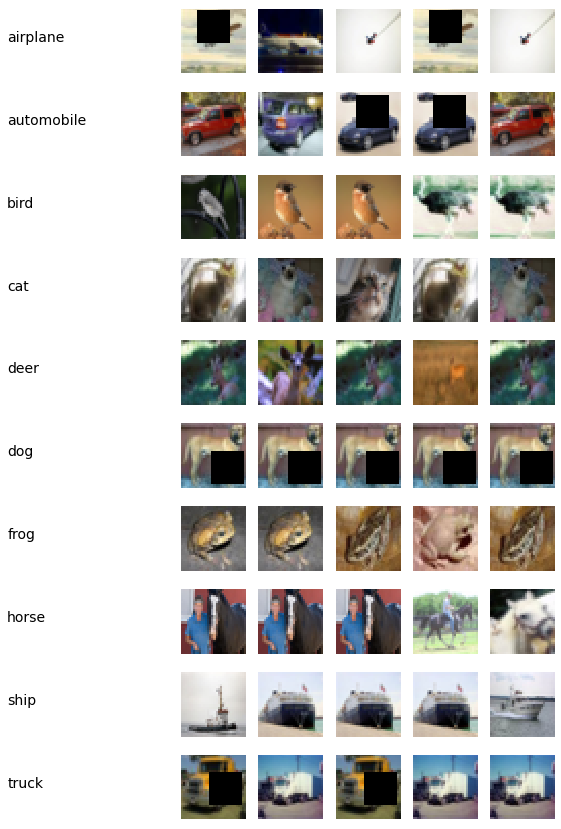

In [15]:
from __future__ import print_function
# channel_means = (0.49196659, 0.48229005, 0.4461573)
# channel_stdevs = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*sdev[i])+mean[i]
  
  return np.transpose(img, (1,2,0))

%matplotlib inline
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 10 images from each category. 
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
r, c = 10, 11
n = 5
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==i)[0], n)
    ax = plt.subplot(r, c, i*c+1)
    ax.text(-1.5, 0.5, class_names[i], fontsize=14)
    plt.axis('off')
    for j in range(1, n+1):
      plt.subplot(r, c, i*c+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

# Code 9: 

In [16]:
# class Net9(nn.Module):
#     def __init__(self):
#         super().__init__()

#         self.block1 = nn.Sequential(
#             cv(3, 16, 3, padding=1),
#             relu(),
#             bn(16),
#             cv(16, 32, 3, dilation=2, groups=8, padding=1),
#             relu(),
#             bn(32),
#             nn.Dropout2d(0.07)
           
#         )

#         self.block2 = nn.Sequential(
#             cv(32, 64, 3, padding=1, dilation=1, groups=8),
#             relu(),
#             bn(64),
#             cv(64, 80, 3, dilation=1, padding=0, groups=4),
#             relu(),
#             bn(80),
#             cv(80, 64, 1),
#             relu(),
#             bn(64),
#             cv(64, 64, 3, padding=1, dilation=2),
#             relu(),
#             bn(64),
#             nn.Dropout2d(0.09)
#             # Conv2d(32, 32, 3, padding=2, dilation=2, stride=2)
#         )

#         self.block3a = nn.Sequential(
#             cv(64, 128, 3, dilation=1, groups=32, stride=1),
#             relu(),
#             bn(128),
#             cv(128, 160, 3, groups=16, dilation=1, padding=1),
#             relu(),
#             bn(160))
        
#         self.block3b = nn.Sequential(
#             cv(160, 64, 1),
#             cv(64, 64, 3, padding=1, groups=16),
#             relu(),
#             bn(64),
#             cv(64, 96, 3, padding=2, dilation=2, stride=2),
#             relu(),
#             bn(96),
#             nn.Dropout2d(0.09)
#         )

#         self.block4 = nn.Sequential(
#             cv(96, 224, 3, padding=1, groups=16, stride=1, dilation=2), # grps 32 changed to 64
#             bn(224),
#             cv(224, 64, 1),
#             bn(64),
#             relu(),
#             nn.Dropout2d(0.05),
#             cv(64, 64, 3, groups=64, padding=1), # depthwise (a)
#             cv(64, 32, 1), # pointwise for preceding depthwise (b)
#             bn(32),
#             relu(),
#             cv(32, 32, 3, dilation=1, groups=16),
#             relu(),
#             bn(32),
#             cv(32, 10, 1),
#             nn.AdaptiveAvgPool2d(1)
#             # cv(10, 10, 1)
#         )
    
        
#     def forward(self, x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3a(x)
#         x = self.block3b(x)
#         x = self.block4(x)
        
#         x = x.view(-1, 10)
#         return F.log_softmax(x, dim=-1)


# model = Net9().to(device)
# summary(model, (3, 32, 32))

In [17]:
# optimizer = optim.SGD(model.parameters(), lr=0.0159, momentum=0.9, nesterov=True) # lr changed
# step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.71) # gamma changed from previous value

# train_losses = []
# train_accuracy = []
# test_losses = []
# test_accuracy = []

# train_eval_model(model, train_loader, optimizer, device, epochs=100, test=True, test_loader=test_loader,scheduler=step_lr)

In [18]:
# plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
#             test_losses=test_losses,test_accuracy=test_accuracy)

# Code 10

In [19]:
class Net10(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            cv(3, 16, 3, padding=1),
            relu(),
            bn(16),
            cv(16, 16, 1),
            relu(),
            bn(16),
            cv(16, 32, 3, dilation=1, groups=1, padding=1),
            relu(),
            bn(32),
            cv(32, 32, 1),
            relu(),
            bn(32),
            nn.Dropout2d(0.05)
        )

        self.block2 = nn.Sequential(
            cv(32, 64, 3, padding=1, dilation=1, groups=32),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32),
            cv(32, 64, 3, dilation=1, padding=1, groups=16),
            relu(),
            bn(64),
            cv(64, 48, 1),
            relu(),
            bn(48),
            cv(48, 64, 3, padding=1, dilation=2, groups=8),
            relu(),
            bn(64),
            cv(64, 32, 1),
            relu(),
            bn(32),
            nn.Dropout2d(0.08)
        )

        self.block3 = nn.Sequential(
            cv(32, 64, 3, dilation=1, padding=1, groups=32, stride=1),
            relu(),
            bn(64),
            cv(64, 128, 3, groups=16, dilation=1, padding=1),
            relu(),
            bn(128),
            cv(128, 64, 1),
            relu(),
            bn(64),
            cv(64, 96, 3, padding=1, groups=32),
            relu(),
            bn(96),
            cv(96, 64, 1),
            relu(),
            bn(64),
            cv(64, 64, 3, padding=2, dilation=2, stride=2),
            relu(),
            bn(64),
            cv(64, 64, 1),
            relu(),
            bn(64),
            nn.Dropout2d(0.09)
            )

        self.block4 = nn.Sequential(
            cv(64, 96, 3, padding=0, groups=32, stride=1, dilation=2),
            bn(96),
            relu(),
            cv(96, 64, 1),
            bn(64),
            relu(),
            nn.Dropout2d(0.05),
            cv(64, 64, 3, groups=64, padding=0, dilation=2), # depthwise (a)
            cv(64, 32, 1), # pointwise for preceding depthwise (b)
            bn(32),
            relu(),
            cv(32, 48, 3, dilation=2, groups=8),
            relu(),
            bn(48),
            cv(48, 10, 1, stride=1),
            relu(),
            bn(10),
            nn.AdaptiveAvgPool2d(1)
            # cv(10, 10, 1)
        )
    
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


model = Net10().to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
            Conv2d-4           [-1, 16, 32, 32]             256
              ReLU-5           [-1, 16, 32, 32]               0
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 32, 32, 32]           4,608
              ReLU-8           [-1, 32, 32, 32]               0
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           1,024
             ReLU-11           [-1, 32, 32, 32]               0
      BatchNorm2d-12           [-1, 32, 32, 32]              64
        Dropout2d-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 64,

In [20]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.87)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []

train_eval_model(model, train_loader, optimizer, device, epochs=30, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.23it/s]


			Train metrics: accuracy: 6654/50000 (13.3080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 2.1976, accuracy: 1803/10000 (18.03000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]


			Train metrics: accuracy: 12326/50000 (24.6520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.8562, accuracy: 3288/10000 (32.88000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.72it/s]


			Train metrics: accuracy: 16111/50000 (32.2220%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.6923, accuracy: 3748/10000 (37.48000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.65it/s]


			Train metrics: accuracy: 18110/50000 (36.2200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.6282, accuracy: 3977/10000 (39.77000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.37it/s]


			Train metrics: accuracy: 19822/50000 (39.6440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.5297, accuracy: 4403/10000 (44.03000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]


			Train metrics: accuracy: 21007/50000 (42.0140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.4778, accuracy: 4529/10000 (45.29000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]


			Train metrics: accuracy: 21772/50000 (43.5440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.4222, accuracy: 4799/10000 (47.99000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.39it/s]


			Train metrics: accuracy: 22599/50000 (45.1980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.3882, accuracy: 4882/10000 (48.82000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.41it/s]


			Train metrics: accuracy: 23278/50000 (46.5560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.3559, accuracy: 5057/10000 (50.57000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.79it/s]


			Train metrics: accuracy: 23983/50000 (47.9660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.3364, accuracy: 5108/10000 (51.08000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.68it/s]


			Train metrics: accuracy: 24893/50000 (49.7860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.2890, accuracy: 5330/10000 (53.30000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.56it/s]


			Train metrics: accuracy: 25422/50000 (50.8440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.2517, accuracy: 5490/10000 (54.90000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.84it/s]


			Train metrics: accuracy: 26116/50000 (52.2320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.2203, accuracy: 5564/10000 (55.64000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:41<00:00, 37.80it/s]


			Train metrics: accuracy: 26609/50000 (53.2180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1783, accuracy: 5743/10000 (57.43000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:41<00:00, 37.62it/s]


			Train metrics: accuracy: 27265/50000 (54.5300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1619, accuracy: 5817/10000 (58.17000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:42<00:00, 37.00it/s]


			Train metrics: accuracy: 27532/50000 (55.0640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1751, accuracy: 5839/10000 (58.39000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:42<00:00, 37.13it/s]


			Train metrics: accuracy: 28033/50000 (56.0660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.1071, accuracy: 6067/10000 (60.67000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.74it/s]


			Train metrics: accuracy: 28621/50000 (57.2420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0866, accuracy: 6101/10000 (61.01000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]


			Train metrics: accuracy: 29059/50000 (58.1180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0856, accuracy: 6153/10000 (61.53000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]


			Train metrics: accuracy: 29457/50000 (58.9140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0489, accuracy: 6277/10000 (62.77000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [00:42<00:00, 37.18it/s]


			Train metrics: accuracy: 29800/50000 (59.6000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0617, accuracy: 6166/10000 (61.66000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [00:41<00:00, 37.39it/s]


			Train metrics: accuracy: 30104/50000 (60.2080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0306, accuracy: 6324/10000 (63.24000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [00:41<00:00, 37.48it/s]


			Train metrics: accuracy: 30517/50000 (61.0340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0333, accuracy: 6369/10000 (63.69000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [00:41<00:00, 37.60it/s]


			Train metrics: accuracy: 30694/50000 (61.3880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0114, accuracy: 6409/10000 (64.09000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]


			Train metrics: accuracy: 31115/50000 (62.2300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9764, accuracy: 6559/10000 (65.59000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [00:41<00:00, 37.36it/s]


			Train metrics: accuracy: 31303/50000 (62.6060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9492, accuracy: 6637/10000 (66.37000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [00:41<00:00, 37.54it/s]


			Train metrics: accuracy: 31716/50000 (63.4320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9518, accuracy: 6662/10000 (66.62000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [00:41<00:00, 37.57it/s]


			Train metrics: accuracy: 32106/50000 (64.2120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9383, accuracy: 6697/10000 (66.97000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [00:41<00:00, 37.53it/s]


			Train metrics: accuracy: 32178/50000 (64.3560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9057, accuracy: 6822/10000 (68.22000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [00:41<00:00, 37.42it/s]


			Train metrics: accuracy: 32416/50000 (64.8320%)



	Test metrics: average loss: 0.9405, accuracy: 6747/10000 (67.47000%)



In [21]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=25, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.18it/s]


			Train metrics: accuracy: 20627/50000 (41.2540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.2782, accuracy: 5603/10000 (56.03000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.56it/s]


			Train metrics: accuracy: 28430/50000 (56.8600%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 1.0349, accuracy: 6393/10000 (63.93000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.88it/s]


			Train metrics: accuracy: 30708/50000 (61.4160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9654, accuracy: 6641/10000 (66.41000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.80it/s]


			Train metrics: accuracy: 32110/50000 (64.2200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9170, accuracy: 6783/10000 (67.83000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.39it/s]


			Train metrics: accuracy: 33315/50000 (66.6300%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8877, accuracy: 6909/10000 (69.09000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.54it/s]


			Train metrics: accuracy: 33813/50000 (67.6260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7996, accuracy: 7226/10000 (72.26000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.87it/s]


			Train metrics: accuracy: 34480/50000 (68.9600%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7636, accuracy: 7369/10000 (73.69000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.71it/s]


			Train metrics: accuracy: 35284/50000 (70.5680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.8250, accuracy: 7130/10000 (71.30000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.70it/s]


			Train metrics: accuracy: 35622/50000 (71.2440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7297, accuracy: 7493/10000 (74.93000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.42it/s]


			Train metrics: accuracy: 36149/50000 (72.2980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7268, accuracy: 7476/10000 (74.76000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.36it/s]


			Train metrics: accuracy: 36478/50000 (72.9560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6869, accuracy: 7589/10000 (75.89000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.39it/s]


			Train metrics: accuracy: 36797/50000 (73.5940%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6717, accuracy: 7673/10000 (76.73000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.44it/s]


			Train metrics: accuracy: 37116/50000 (74.2320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7212, accuracy: 7509/10000 (75.09000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]


			Train metrics: accuracy: 37318/50000 (74.6360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6704, accuracy: 7676/10000 (76.76000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:41<00:00, 37.44it/s]


			Train metrics: accuracy: 37678/50000 (75.3560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6535, accuracy: 7752/10000 (77.52000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]


			Train metrics: accuracy: 37897/50000 (75.7940%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6514, accuracy: 7798/10000 (77.98000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]


			Train metrics: accuracy: 38119/50000 (76.2380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6640, accuracy: 7788/10000 (77.88000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.48it/s]


			Train metrics: accuracy: 38304/50000 (76.6080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5937, accuracy: 7928/10000 (79.28000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.65it/s]


			Train metrics: accuracy: 38498/50000 (76.9960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6331, accuracy: 7818/10000 (78.18000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:41<00:00, 37.40it/s]


			Train metrics: accuracy: 38707/50000 (77.4140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6289, accuracy: 7850/10000 (78.50000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [00:41<00:00, 37.59it/s]


			Train metrics: accuracy: 38845/50000 (77.6900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6301, accuracy: 7860/10000 (78.60000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [00:41<00:00, 37.78it/s]


			Train metrics: accuracy: 38996/50000 (77.9920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6309, accuracy: 7873/10000 (78.73000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [00:41<00:00, 37.74it/s]


			Train metrics: accuracy: 39374/50000 (78.7480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6000, accuracy: 7925/10000 (79.25000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [00:41<00:00, 37.84it/s]


			Train metrics: accuracy: 39413/50000 (78.8260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6251, accuracy: 7903/10000 (79.03000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]


			Train metrics: accuracy: 39362/50000 (78.7240%)



	Test metrics: average loss: 0.5957, accuracy: 7983/10000 (79.83000%)



In [43]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=10, test=True, test_loader=test_loader,scheduler=None)
torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.28it/s]


			Train metrics: accuracy: 30384/50000 (60.7680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7446, accuracy: 7498/10000 (74.98000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.87it/s]


			Train metrics: accuracy: 34476/50000 (68.9520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.9153, accuracy: 6950/10000 (69.50000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.82it/s]


			Train metrics: accuracy: 35577/50000 (71.1540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7051, accuracy: 7561/10000 (75.61000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.67it/s]


			Train metrics: accuracy: 36173/50000 (72.3460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7642, accuracy: 7446/10000 (74.46000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.75it/s]


			Train metrics: accuracy: 36725/50000 (73.4500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6116, accuracy: 7855/10000 (78.55000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.57it/s]


			Train metrics: accuracy: 37202/50000 (74.4040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6421, accuracy: 7747/10000 (77.47000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]


			Train metrics: accuracy: 37572/50000 (75.1440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6262, accuracy: 7846/10000 (78.46000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]


			Train metrics: accuracy: 37936/50000 (75.8720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6012, accuracy: 7929/10000 (79.29000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.26it/s]


			Train metrics: accuracy: 38182/50000 (76.3640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.6039, accuracy: 7917/10000 (79.17000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.37it/s]


			Train metrics: accuracy: 38536/50000 (77.0720%)



	Test metrics: average loss: 0.7569, accuracy: 7553/10000 (75.53000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.36it/s]


			Train metrics: accuracy: 37540/50000 (75.0800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4877, accuracy: 8363/10000 (83.63000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.55it/s]


			Train metrics: accuracy: 40751/50000 (81.5020%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4834, accuracy: 8371/10000 (83.71000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]


			Train metrics: accuracy: 40927/50000 (81.8540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4925, accuracy: 8340/10000 (83.40000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]


			Train metrics: accuracy: 40999/50000 (81.9980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4902, accuracy: 8300/10000 (83.00000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]


			Train metrics: accuracy: 41099/50000 (82.1980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5026, accuracy: 8307/10000 (83.07000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.80it/s]


			Train metrics: accuracy: 41260/50000 (82.5200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4819, accuracy: 8386/10000 (83.86000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.80it/s]


			Train metrics: accuracy: 41249/50000 (82.4980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4682, accuracy: 8388/10000 (83.88000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.69it/s]


			Train metrics: accuracy: 41274/50000 (82.5480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4622, accuracy: 8459/10000 (84.59000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.71it/s]


			Train metrics: accuracy: 41380/50000 (82.7600%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4743, accuracy: 8395/10000 (83.95000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.81it/s]


			Train metrics: accuracy: 41571/50000 (83.1420%)



	Test metrics: average loss: 0.5195, accuracy: 8267/10000 (82.67000%)



In [44]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
# step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=25, test=True, test_loader=test_loader,scheduler=None)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.18it/s]


			Train metrics: accuracy: 33204/50000 (66.4080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.7624, accuracy: 7924/10000 (79.24000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]


			Train metrics: accuracy: 39043/50000 (78.0860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5887, accuracy: 8030/10000 (80.30000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.76it/s]


			Train metrics: accuracy: 39591/50000 (79.1820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5482, accuracy: 8121/10000 (81.21000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.40it/s]


			Train metrics: accuracy: 40027/50000 (80.0540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5289, accuracy: 8181/10000 (81.81000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.30it/s]


			Train metrics: accuracy: 40267/50000 (80.5340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5153, accuracy: 8238/10000 (82.38000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.43it/s]


			Train metrics: accuracy: 40528/50000 (81.0560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5093, accuracy: 8263/10000 (82.63000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.58it/s]


			Train metrics: accuracy: 40469/50000 (80.9380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5013, accuracy: 8285/10000 (82.85000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.58it/s]


			Train metrics: accuracy: 40604/50000 (81.2080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4954, accuracy: 8310/10000 (83.10000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.41it/s]


			Train metrics: accuracy: 40809/50000 (81.6180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4937, accuracy: 8314/10000 (83.14000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.31it/s]


			Train metrics: accuracy: 40922/50000 (81.8440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4909, accuracy: 8331/10000 (83.31000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]


			Train metrics: accuracy: 41032/50000 (82.0640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4884, accuracy: 8334/10000 (83.34000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]


			Train metrics: accuracy: 41060/50000 (82.1200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4835, accuracy: 8355/10000 (83.55000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]


			Train metrics: accuracy: 41053/50000 (82.1060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4802, accuracy: 8345/10000 (83.45000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:41<00:00, 37.32it/s]


			Train metrics: accuracy: 41213/50000 (82.4260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4811, accuracy: 8346/10000 (83.46000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:41<00:00, 37.31it/s]


			Train metrics: accuracy: 41175/50000 (82.3500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4776, accuracy: 8370/10000 (83.70000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:42<00:00, 37.07it/s]


			Train metrics: accuracy: 41287/50000 (82.5740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4748, accuracy: 8372/10000 (83.72000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:42<00:00, 37.02it/s]


			Train metrics: accuracy: 41338/50000 (82.6760%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4738, accuracy: 8371/10000 (83.71000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.46it/s]


			Train metrics: accuracy: 41290/50000 (82.5800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4717, accuracy: 8375/10000 (83.75000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.24it/s]


			Train metrics: accuracy: 41518/50000 (83.0360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4705, accuracy: 8389/10000 (83.89000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:42<00:00, 37.19it/s]


			Train metrics: accuracy: 41459/50000 (82.9180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4712, accuracy: 8364/10000 (83.64000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [00:41<00:00, 37.31it/s]


			Train metrics: accuracy: 41574/50000 (83.1480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4682, accuracy: 8385/10000 (83.85000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [00:41<00:00, 37.89it/s]


			Train metrics: accuracy: 41542/50000 (83.0840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4671, accuracy: 8394/10000 (83.94000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]


			Train metrics: accuracy: 41717/50000 (83.4340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4659, accuracy: 8392/10000 (83.92000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [00:41<00:00, 37.29it/s]


			Train metrics: accuracy: 41534/50000 (83.0680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4648, accuracy: 8417/10000 (84.17000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [00:41<00:00, 37.44it/s]


			Train metrics: accuracy: 41615/50000 (83.2300%)



	Test metrics: average loss: 0.4623, accuracy: 8401/10000 (84.01000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.21it/s]


			Train metrics: accuracy: 36168/50000 (72.3360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4943, accuracy: 8354/10000 (83.54000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.53it/s]


			Train metrics: accuracy: 42153/50000 (84.3060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4386, accuracy: 8509/10000 (85.09000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.79it/s]


			Train metrics: accuracy: 42613/50000 (85.2260%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4247, accuracy: 8527/10000 (85.27000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.76it/s]


			Train metrics: accuracy: 42823/50000 (85.6460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4154, accuracy: 8547/10000 (85.47000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]


			Train metrics: accuracy: 42942/50000 (85.8840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4104, accuracy: 8573/10000 (85.73000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.60it/s]


			Train metrics: accuracy: 43106/50000 (86.2120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4066, accuracy: 8588/10000 (85.88000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.48it/s]


			Train metrics: accuracy: 43081/50000 (86.1620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4041, accuracy: 8602/10000 (86.02000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.71it/s]


			Train metrics: accuracy: 43281/50000 (86.5620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4035, accuracy: 8605/10000 (86.05000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.61it/s]


			Train metrics: accuracy: 43227/50000 (86.4540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4015, accuracy: 8615/10000 (86.15000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.61it/s]


			Train metrics: accuracy: 43395/50000 (86.7900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3978, accuracy: 8637/10000 (86.37000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.48it/s]


			Train metrics: accuracy: 43440/50000 (86.8800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3985, accuracy: 8634/10000 (86.34000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.61it/s]


			Train metrics: accuracy: 43514/50000 (87.0280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3988, accuracy: 8626/10000 (86.26000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]


			Train metrics: accuracy: 43538/50000 (87.0760%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3954, accuracy: 8642/10000 (86.42000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:41<00:00, 37.72it/s]


			Train metrics: accuracy: 43583/50000 (87.1660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3954, accuracy: 8639/10000 (86.39000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]


			Train metrics: accuracy: 43568/50000 (87.1360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3936, accuracy: 8652/10000 (86.52000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]


			Train metrics: accuracy: 43654/50000 (87.3080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3949, accuracy: 8636/10000 (86.36000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:41<00:00, 37.72it/s]


			Train metrics: accuracy: 43703/50000 (87.4060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3941, accuracy: 8647/10000 (86.47000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.55it/s]


			Train metrics: accuracy: 43726/50000 (87.4520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3926, accuracy: 8645/10000 (86.45000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.67it/s]


			Train metrics: accuracy: 43780/50000 (87.5600%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3920, accuracy: 8661/10000 (86.61000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:41<00:00, 37.48it/s]


			Train metrics: accuracy: 43791/50000 (87.5820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3914, accuracy: 8654/10000 (86.54000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [00:41<00:00, 37.28it/s]


			Train metrics: accuracy: 43910/50000 (87.8200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3908, accuracy: 8670/10000 (86.70000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]


			Train metrics: accuracy: 43871/50000 (87.7420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3903, accuracy: 8675/10000 (86.75000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [00:41<00:00, 37.87it/s]


			Train metrics: accuracy: 43992/50000 (87.9840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3911, accuracy: 8664/10000 (86.64000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]


			Train metrics: accuracy: 43952/50000 (87.9040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3918, accuracy: 8651/10000 (86.51000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [00:41<00:00, 37.73it/s]


			Train metrics: accuracy: 43927/50000 (87.8540%)



	Test metrics: average loss: 0.3898, accuracy: 8660/10000 (86.60000%)



In [45]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=20, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.39it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 37919/50000 (75.8380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4235, accuracy: 8550/10000 (85.50000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.58it/s]



			Last LR --> [0.0008100000000000001]

			Train metrics: accuracy: 43537/50000 (87.0740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3939, accuracy: 8642/10000 (86.42000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.48it/s]



			Last LR --> [0.0006561000000000001]

			Train metrics: accuracy: 43876/50000 (87.7520%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3885, accuracy: 8691/10000 (86.91000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.62it/s]



			Last LR --> [0.0005314410000000001]

			Train metrics: accuracy: 44016/50000 (88.0320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3866, accuracy: 8673/10000 (86.73000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.71it/s]



			Last LR --> [0.0004304672100000001]

			Train metrics: accuracy: 44106/50000 (88.2120%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3838, accuracy: 8693/10000 (86.93000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]



			Last LR --> [0.0003486784401000001]

			Train metrics: accuracy: 44268/50000 (88.5360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3846, accuracy: 8683/10000 (86.83000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.38it/s]



			Last LR --> [0.0002824295364810001]

			Train metrics: accuracy: 44237/50000 (88.4740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3845, accuracy: 8683/10000 (86.83000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.59it/s]



			Last LR --> [0.00022876792454961008]

			Train metrics: accuracy: 44252/50000 (88.5040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3815, accuracy: 8707/10000 (87.07000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.58it/s]



			Last LR --> [0.00018530201888518417]

			Train metrics: accuracy: 44305/50000 (88.6100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3821, accuracy: 8714/10000 (87.14000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]



			Last LR --> [0.00015009463529699917]

			Train metrics: accuracy: 44368/50000 (88.7360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3820, accuracy: 8699/10000 (86.99000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.28it/s]



			Last LR --> [0.00012157665459056933]

			Train metrics: accuracy: 44305/50000 (88.6100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3820, accuracy: 8703/10000 (87.03000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.25it/s]



			Last LR --> [9.847709021836117e-05]

			Train metrics: accuracy: 44468/50000 (88.9360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3823, accuracy: 8705/10000 (87.05000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.69it/s]



			Last LR --> [7.976644307687255e-05]

			Train metrics: accuracy: 44404/50000 (88.8080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3816, accuracy: 8712/10000 (87.12000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]



			Last LR --> [6.461081889226677e-05]

			Train metrics: accuracy: 44436/50000 (88.8720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3825, accuracy: 8715/10000 (87.15000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:41<00:00, 37.62it/s]



			Last LR --> [5.233476330273609e-05]

			Train metrics: accuracy: 44440/50000 (88.8800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3809, accuracy: 8706/10000 (87.06000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:41<00:00, 37.32it/s]



			Last LR --> [4.239115827521624e-05]

			Train metrics: accuracy: 44496/50000 (88.9920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3821, accuracy: 8706/10000 (87.06000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:41<00:00, 37.31it/s]



			Last LR --> [3.433683820292516e-05]

			Train metrics: accuracy: 44373/50000 (88.7460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3819, accuracy: 8709/10000 (87.09000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.56it/s]



			Last LR --> [2.781283894436938e-05]

			Train metrics: accuracy: 44395/50000 (88.7900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3814, accuracy: 8710/10000 (87.10000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]



			Last LR --> [2.25283995449392e-05]

			Train metrics: accuracy: 44473/50000 (88.9460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3819, accuracy: 8704/10000 (87.04000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:41<00:00, 37.28it/s]



			Last LR --> [1.824800363140075e-05]

			Train metrics: accuracy: 44487/50000 (88.9740%)



	Test metrics: average loss: 0.3814, accuracy: 8715/10000 (87.15000%)



In [46]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=5, gamma=0.81)


train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.27it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 38462/50000 (76.9240%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4012, accuracy: 8632/10000 (86.32000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.72it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 43949/50000 (87.8980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3813, accuracy: 8704/10000 (87.04000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.75it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 44222/50000 (88.4440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3851, accuracy: 8692/10000 (86.92000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.96it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 44273/50000 (88.5460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3930, accuracy: 8658/10000 (86.58000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.66it/s]



			Last LR --> [0.001]

			Train metrics: accuracy: 44502/50000 (89.0040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3847, accuracy: 8680/10000 (86.80000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.53it/s]



			Last LR --> [0.0008100000000000001]

			Train metrics: accuracy: 44449/50000 (88.8980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3839, accuracy: 8705/10000 (87.05000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.57it/s]



			Last LR --> [0.0008100000000000001]

			Train metrics: accuracy: 44605/50000 (89.2100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3792, accuracy: 8726/10000 (87.26000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.74it/s]



			Last LR --> [0.0008100000000000001]

			Train metrics: accuracy: 44692/50000 (89.3840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3817, accuracy: 8728/10000 (87.28000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.77it/s]



			Last LR --> [0.0008100000000000001]

			Train metrics: accuracy: 44753/50000 (89.5060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3868, accuracy: 8706/10000 (87.06000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]



			Last LR --> [0.0008100000000000001]

			Train metrics: accuracy: 44712/50000 (89.4240%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3848, accuracy: 8720/10000 (87.20000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.53it/s]



			Last LR --> [0.0006561000000000001]

			Train metrics: accuracy: 44752/50000 (89.5040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3797, accuracy: 8749/10000 (87.49000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]



			Last LR --> [0.0006561000000000001]

			Train metrics: accuracy: 44773/50000 (89.5460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3839, accuracy: 8718/10000 (87.18000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.55it/s]



			Last LR --> [0.0006561000000000001]

			Train metrics: accuracy: 44875/50000 (89.7500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3880, accuracy: 8733/10000 (87.33000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:41<00:00, 37.68it/s]



			Last LR --> [0.0006561000000000001]

			Train metrics: accuracy: 44862/50000 (89.7240%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3871, accuracy: 8713/10000 (87.13000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:41<00:00, 37.59it/s]



			Last LR --> [0.0006561000000000001]

			Train metrics: accuracy: 44829/50000 (89.6580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3857, accuracy: 8709/10000 (87.09000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]



			Last LR --> [0.0005314410000000001]

			Train metrics: accuracy: 44944/50000 (89.8880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3863, accuracy: 8731/10000 (87.31000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:41<00:00, 37.37it/s]



			Last LR --> [0.0005314410000000001]

			Train metrics: accuracy: 44943/50000 (89.8860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3862, accuracy: 8747/10000 (87.47000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.73it/s]



			Last LR --> [0.0005314410000000001]

			Train metrics: accuracy: 45042/50000 (90.0840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3818, accuracy: 8754/10000 (87.54000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]



			Last LR --> [0.0005314410000000001]

			Train metrics: accuracy: 44987/50000 (89.9740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3883, accuracy: 8731/10000 (87.31000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:41<00:00, 37.44it/s]



			Last LR --> [0.0005314410000000001]

			Train metrics: accuracy: 45028/50000 (90.0560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3869, accuracy: 8734/10000 (87.34000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [00:41<00:00, 37.57it/s]



			Last LR --> [0.0004304672100000001]

			Train metrics: accuracy: 45078/50000 (90.1560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3874, accuracy: 8739/10000 (87.39000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [00:41<00:00, 37.71it/s]



			Last LR --> [0.0004304672100000001]

			Train metrics: accuracy: 45150/50000 (90.3000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3811, accuracy: 8757/10000 (87.57000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [00:41<00:00, 37.61it/s]



			Last LR --> [0.0004304672100000001]

			Train metrics: accuracy: 45167/50000 (90.3340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3839, accuracy: 8741/10000 (87.41000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]



			Last LR --> [0.0004304672100000001]

			Train metrics: accuracy: 45074/50000 (90.1480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3811, accuracy: 8748/10000 (87.48000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]



			Last LR --> [0.0004304672100000001]

			Train metrics: accuracy: 45190/50000 (90.3800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3829, accuracy: 8748/10000 (87.48000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [00:41<00:00, 37.30it/s]



			Last LR --> [0.0003486784401000001]

			Train metrics: accuracy: 45260/50000 (90.5200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3841, accuracy: 8746/10000 (87.46000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [00:41<00:00, 37.61it/s]



			Last LR --> [0.0003486784401000001]

			Train metrics: accuracy: 45216/50000 (90.4320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3843, accuracy: 8752/10000 (87.52000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]



			Last LR --> [0.0003486784401000001]

			Train metrics: accuracy: 45231/50000 (90.4620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3842, accuracy: 8743/10000 (87.43000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [00:41<00:00, 37.58it/s]



			Last LR --> [0.0003486784401000001]

			Train metrics: accuracy: 45124/50000 (90.2480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3829, accuracy: 8744/10000 (87.44000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [00:42<00:00, 37.07it/s]



			Last LR --> [0.0003486784401000001]

			Train metrics: accuracy: 45305/50000 (90.6100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3866, accuracy: 8757/10000 (87.57000%)


 epoch num ================================= 31


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]



			Last LR --> [0.0002824295364810001]

			Train metrics: accuracy: 45259/50000 (90.5180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3823, accuracy: 8753/10000 (87.53000%)


 epoch num ================================= 32


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]



			Last LR --> [0.0002824295364810001]

			Train metrics: accuracy: 45339/50000 (90.6780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3837, accuracy: 8772/10000 (87.72000%)


 epoch num ================================= 33


100%|██████████| 1563/1563 [00:41<00:00, 37.59it/s]



			Last LR --> [0.0002824295364810001]

			Train metrics: accuracy: 45436/50000 (90.8720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3832, accuracy: 8757/10000 (87.57000%)


 epoch num ================================= 34


100%|██████████| 1563/1563 [00:41<00:00, 37.32it/s]



			Last LR --> [0.0002824295364810001]

			Train metrics: accuracy: 45354/50000 (90.7080%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3884, accuracy: 8737/10000 (87.37000%)


 epoch num ================================= 35


100%|██████████| 1563/1563 [00:41<00:00, 37.29it/s]



			Last LR --> [0.0002824295364810001]

			Train metrics: accuracy: 45353/50000 (90.7060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3859, accuracy: 8746/10000 (87.46000%)


 epoch num ================================= 36


100%|██████████| 1563/1563 [00:42<00:00, 37.04it/s]



			Last LR --> [0.00022876792454961008]

			Train metrics: accuracy: 45339/50000 (90.6780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3865, accuracy: 8743/10000 (87.43000%)


 epoch num ================================= 37


100%|██████████| 1563/1563 [00:41<00:00, 37.42it/s]



			Last LR --> [0.00022876792454961008]

			Train metrics: accuracy: 45372/50000 (90.7440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3832, accuracy: 8770/10000 (87.70000%)


 epoch num ================================= 38


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]



			Last LR --> [0.00022876792454961008]

			Train metrics: accuracy: 45323/50000 (90.6460%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3844, accuracy: 8764/10000 (87.64000%)


 epoch num ================================= 39


100%|██████████| 1563/1563 [00:41<00:00, 37.55it/s]



			Last LR --> [0.00022876792454961008]

			Train metrics: accuracy: 45279/50000 (90.5580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3830, accuracy: 8758/10000 (87.58000%)


 epoch num ================================= 40


100%|██████████| 1563/1563 [00:41<00:00, 37.22it/s]



			Last LR --> [0.00022876792454961008]

			Train metrics: accuracy: 45371/50000 (90.7420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3865, accuracy: 8760/10000 (87.60000%)


 epoch num ================================= 41


100%|██████████| 1563/1563 [00:41<00:00, 37.26it/s]



			Last LR --> [0.00018530201888518417]

			Train metrics: accuracy: 45443/50000 (90.8860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3848, accuracy: 8766/10000 (87.66000%)


 epoch num ================================= 42


100%|██████████| 1563/1563 [00:41<00:00, 37.35it/s]



			Last LR --> [0.00018530201888518417]

			Train metrics: accuracy: 45342/50000 (90.6840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3865, accuracy: 8746/10000 (87.46000%)


 epoch num ================================= 43


100%|██████████| 1563/1563 [00:41<00:00, 37.31it/s]



			Last LR --> [0.00018530201888518417]

			Train metrics: accuracy: 45546/50000 (91.0920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3874, accuracy: 8759/10000 (87.59000%)


 epoch num ================================= 44


100%|██████████| 1563/1563 [00:41<00:00, 37.27it/s]



			Last LR --> [0.00018530201888518417]

			Train metrics: accuracy: 45422/50000 (90.8440%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3838, accuracy: 8764/10000 (87.64000%)


 epoch num ================================= 45


100%|██████████| 1563/1563 [00:41<00:00, 37.34it/s]



			Last LR --> [0.00018530201888518417]

			Train metrics: accuracy: 45424/50000 (90.8480%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3861, accuracy: 8741/10000 (87.41000%)


 epoch num ================================= 46


100%|██████████| 1563/1563 [00:41<00:00, 37.30it/s]



			Last LR --> [0.00015009463529699917]

			Train metrics: accuracy: 45489/50000 (90.9780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3848, accuracy: 8762/10000 (87.62000%)


 epoch num ================================= 47


100%|██████████| 1563/1563 [00:42<00:00, 37.17it/s]



			Last LR --> [0.00015009463529699917]

			Train metrics: accuracy: 45505/50000 (91.0100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3846, accuracy: 8759/10000 (87.59000%)


 epoch num ================================= 48


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]



			Last LR --> [0.00015009463529699917]

			Train metrics: accuracy: 45550/50000 (91.1000%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3866, accuracy: 8751/10000 (87.51000%)


 epoch num ================================= 49


100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]



			Last LR --> [0.00015009463529699917]

			Train metrics: accuracy: 45617/50000 (91.2340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.3894, accuracy: 8756/10000 (87.56000%)


 epoch num ================================= 50


100%|██████████| 1563/1563 [00:42<00:00, 36.91it/s]



			Last LR --> [0.00015009463529699917]

			Train metrics: accuracy: 45518/50000 (91.0360%)



	Test metrics: average loss: 0.3875, accuracy: 8767/10000 (87.67000%)



In [26]:
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=1, gamma=0.69)


train_eval_model(model, train_loader, optimizer, device, epochs=20, test=True, test_loader=test_loader,scheduler=None)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.22it/s]


			Train metrics: accuracy: 35421/50000 (70.8420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5571, accuracy: 8263/10000 (82.63000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.62it/s]


			Train metrics: accuracy: 41094/50000 (82.1880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4736, accuracy: 8402/10000 (84.02000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.61it/s]


			Train metrics: accuracy: 41564/50000 (83.1280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4667, accuracy: 8411/10000 (84.11000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.28it/s]


			Train metrics: accuracy: 41684/50000 (83.3680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4611, accuracy: 8393/10000 (83.93000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.39it/s]


			Train metrics: accuracy: 41816/50000 (83.6320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4541, accuracy: 8417/10000 (84.17000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.54it/s]


			Train metrics: accuracy: 41866/50000 (83.7320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4522, accuracy: 8418/10000 (84.18000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.57it/s]


			Train metrics: accuracy: 41994/50000 (83.9880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4503, accuracy: 8437/10000 (84.37000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.53it/s]


			Train metrics: accuracy: 42110/50000 (84.2200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4495, accuracy: 8458/10000 (84.58000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:42<00:00, 37.11it/s]


			Train metrics: accuracy: 42093/50000 (84.1860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4475, accuracy: 8452/10000 (84.52000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.56it/s]


			Train metrics: accuracy: 42370/50000 (84.7400%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4415, accuracy: 8488/10000 (84.88000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]


			Train metrics: accuracy: 42359/50000 (84.7180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4464, accuracy: 8434/10000 (84.34000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.24it/s]


			Train metrics: accuracy: 42488/50000 (84.9760%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4466, accuracy: 8450/10000 (84.50000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.75it/s]


			Train metrics: accuracy: 42430/50000 (84.8600%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4408, accuracy: 8465/10000 (84.65000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]


			Train metrics: accuracy: 42484/50000 (84.9680%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4437, accuracy: 8467/10000 (84.67000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]


			Train metrics: accuracy: 42552/50000 (85.1040%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4378, accuracy: 8485/10000 (84.85000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]


			Train metrics: accuracy: 42559/50000 (85.1180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4400, accuracy: 8472/10000 (84.72000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:41<00:00, 37.54it/s]


			Train metrics: accuracy: 42742/50000 (85.4840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4352, accuracy: 8515/10000 (85.15000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.42it/s]


			Train metrics: accuracy: 42729/50000 (85.4580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4346, accuracy: 8501/10000 (85.01000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.29it/s]


			Train metrics: accuracy: 42777/50000 (85.5540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4339, accuracy: 8538/10000 (85.38000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]


			Train metrics: accuracy: 42868/50000 (85.7360%)



	Test metrics: average loss: 0.4367, accuracy: 8530/10000 (85.30000%)



In [27]:
torch.save(model, "./s7_exp_2.pth")

In [28]:
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.71)


train_eval_model(model, train_loader, optimizer, device, epochs=20, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:43<00:00, 35.80it/s]



			Last LR --> [0.0001]

			Train metrics: accuracy: 35855/50000 (71.7100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5128, accuracy: 8361/10000 (83.61000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:40<00:00, 38.37it/s]



			Last LR --> [0.0001]

			Train metrics: accuracy: 42081/50000 (84.1620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4539, accuracy: 8472/10000 (84.72000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:40<00:00, 38.49it/s]



			Last LR --> [7.1e-05]

			Train metrics: accuracy: 42346/50000 (84.6920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4442, accuracy: 8474/10000 (84.74000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:40<00:00, 38.25it/s]



			Last LR --> [7.1e-05]

			Train metrics: accuracy: 42496/50000 (84.9920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4406, accuracy: 8478/10000 (84.78000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 38.11it/s]



			Last LR --> [5.041e-05]

			Train metrics: accuracy: 42379/50000 (84.7580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4380, accuracy: 8491/10000 (84.91000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 38.07it/s]



			Last LR --> [5.041e-05]

			Train metrics: accuracy: 42533/50000 (85.0660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4371, accuracy: 8487/10000 (84.87000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:40<00:00, 38.49it/s]



			Last LR --> [3.57911e-05]

			Train metrics: accuracy: 42667/50000 (85.3340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4357, accuracy: 8495/10000 (84.95000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.95it/s]



			Last LR --> [3.57911e-05]

			Train metrics: accuracy: 42575/50000 (85.1500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4349, accuracy: 8492/10000 (84.92000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.61it/s]



			Last LR --> [2.5411680999999997e-05]

			Train metrics: accuracy: 42646/50000 (85.2920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4340, accuracy: 8495/10000 (84.95000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]



			Last LR --> [2.5411680999999997e-05]

			Train metrics: accuracy: 42703/50000 (85.4060%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4341, accuracy: 8504/10000 (85.04000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.65it/s]



			Last LR --> [1.8042293509999997e-05]

			Train metrics: accuracy: 42698/50000 (85.3960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4339, accuracy: 8503/10000 (85.03000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]



			Last LR --> [1.8042293509999997e-05]

			Train metrics: accuracy: 42646/50000 (85.2920%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4332, accuracy: 8505/10000 (85.05000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.36it/s]



			Last LR --> [1.2810028392099997e-05]

			Train metrics: accuracy: 42669/50000 (85.3380%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4337, accuracy: 8508/10000 (85.08000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:42<00:00, 36.98it/s]



			Last LR --> [1.2810028392099997e-05]

			Train metrics: accuracy: 42736/50000 (85.4720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4336, accuracy: 8503/10000 (85.03000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:42<00:00, 37.01it/s]



			Last LR --> [9.095120158390997e-06]

			Train metrics: accuracy: 42742/50000 (85.4840%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4334, accuracy: 8504/10000 (85.04000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]



			Last LR --> [9.095120158390997e-06]

			Train metrics: accuracy: 42727/50000 (85.4540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4334, accuracy: 8504/10000 (85.04000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:41<00:00, 37.24it/s]



			Last LR --> [6.457535312457608e-06]

			Train metrics: accuracy: 42697/50000 (85.3940%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4331, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.56it/s]



			Last LR --> [6.457535312457608e-06]

			Train metrics: accuracy: 42795/50000 (85.5900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4332, accuracy: 8506/10000 (85.06000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]



			Last LR --> [4.5848500718449016e-06]

			Train metrics: accuracy: 42737/50000 (85.4740%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4332, accuracy: 8507/10000 (85.07000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:41<00:00, 37.74it/s]



			Last LR --> [4.5848500718449016e-06]

			Train metrics: accuracy: 42732/50000 (85.4640%)



	Test metrics: average loss: 0.4332, accuracy: 8506/10000 (85.06000%)



In [30]:
optimizer = optim.SGD(model.parameters(), lr=0.009, momentum=0.9, nesterov=True) #0.097, 0.13 works with gamma=0.71 and batch=64 withoit nan loss
step_lr = StepLR(optimizer=optimizer, step_size=2, gamma=0.71)


train_eval_model(model, train_loader, optimizer, device, epochs=50, test=True, test_loader=test_loader,scheduler=step_lr)

torch.save(model, "./s7_exp_2.pth")

  0%|          | 0/1563 [00:00<?, ?it/s]


 epoch num ================================= 1


100%|██████████| 1563/1563 [00:44<00:00, 35.25it/s]



			Last LR --> [0.009]

			Train metrics: accuracy: 36516/50000 (73.0320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4945, accuracy: 8316/10000 (83.16000%)


 epoch num ================================= 2


100%|██████████| 1563/1563 [00:41<00:00, 37.25it/s]




			Last LR --> [0.009]

			Train metrics: accuracy: 40047/50000 (80.0940%)


  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.5846, accuracy: 8001/10000 (80.01000%)


 epoch num ================================= 3


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 40945/50000 (81.8900%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4855, accuracy: 8355/10000 (83.55000%)


 epoch num ================================= 4


100%|██████████| 1563/1563 [00:41<00:00, 37.69it/s]



			Last LR --> [0.006389999999999999]

			Train metrics: accuracy: 41093/50000 (82.1860%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4993, accuracy: 8309/10000 (83.09000%)


 epoch num ================================= 5


100%|██████████| 1563/1563 [00:41<00:00, 37.67it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 41882/50000 (83.7640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4754, accuracy: 8398/10000 (83.98000%)


 epoch num ================================= 6


100%|██████████| 1563/1563 [00:41<00:00, 37.78it/s]



			Last LR --> [0.004536899999999999]

			Train metrics: accuracy: 41967/50000 (83.9340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4573, accuracy: 8469/10000 (84.69000%)


 epoch num ================================= 7


100%|██████████| 1563/1563 [00:41<00:00, 37.53it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 42486/50000 (84.9720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4389, accuracy: 8522/10000 (85.22000%)


 epoch num ================================= 8


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]



			Last LR --> [0.0032211989999999992]

			Train metrics: accuracy: 42633/50000 (85.2660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4346, accuracy: 8569/10000 (85.69000%)


 epoch num ================================= 9


100%|██████████| 1563/1563 [00:41<00:00, 37.64it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 43039/50000 (86.0780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4330, accuracy: 8566/10000 (85.66000%)


 epoch num ================================= 10


100%|██████████| 1563/1563 [00:41<00:00, 37.76it/s]



			Last LR --> [0.0022870512899999993]

			Train metrics: accuracy: 43233/50000 (86.4660%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4237, accuracy: 8583/10000 (85.83000%)


 epoch num ================================= 11


100%|██████████| 1563/1563 [00:41<00:00, 37.53it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 43507/50000 (87.0140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4129, accuracy: 8604/10000 (86.04000%)


 epoch num ================================= 12


100%|██████████| 1563/1563 [00:41<00:00, 37.24it/s]



			Last LR --> [0.0016238064158999993]

			Train metrics: accuracy: 43536/50000 (87.0720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4257, accuracy: 8573/10000 (85.73000%)


 epoch num ================================= 13


100%|██████████| 1563/1563 [00:41<00:00, 37.62it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 43898/50000 (87.7960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4162, accuracy: 8579/10000 (85.79000%)


 epoch num ================================= 14


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]



			Last LR --> [0.0011529025552889994]

			Train metrics: accuracy: 43994/50000 (87.9880%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4177, accuracy: 8616/10000 (86.16000%)


 epoch num ================================= 15


100%|██████████| 1563/1563 [00:41<00:00, 37.91it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 44139/50000 (88.2780%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4262, accuracy: 8599/10000 (85.99000%)


 epoch num ================================= 16


100%|██████████| 1563/1563 [00:41<00:00, 37.72it/s]



			Last LR --> [0.0008185608142551895]

			Train metrics: accuracy: 44171/50000 (88.3420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4121, accuracy: 8610/10000 (86.10000%)


 epoch num ================================= 17


100%|██████████| 1563/1563 [00:41<00:00, 37.54it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 44230/50000 (88.4600%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4169, accuracy: 8615/10000 (86.15000%)


 epoch num ================================= 18


100%|██████████| 1563/1563 [00:41<00:00, 37.44it/s]



			Last LR --> [0.0005811781781211845]

			Train metrics: accuracy: 44501/50000 (89.0020%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4101, accuracy: 8642/10000 (86.42000%)


 epoch num ================================= 19


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]



			Last LR --> [0.00041263650646604095]

			Train metrics: accuracy: 44429/50000 (88.8580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4110, accuracy: 8644/10000 (86.44000%)


 epoch num ================================= 20


100%|██████████| 1563/1563 [00:41<00:00, 37.37it/s]



			Last LR --> [0.00041263650646604095]

			Train metrics: accuracy: 44605/50000 (89.2100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4126, accuracy: 8633/10000 (86.33000%)


 epoch num ================================= 21


100%|██████████| 1563/1563 [00:41<00:00, 37.56it/s]



			Last LR --> [0.00029297191959088906]

			Train metrics: accuracy: 44636/50000 (89.2720%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4119, accuracy: 8642/10000 (86.42000%)


 epoch num ================================= 22


100%|██████████| 1563/1563 [00:41<00:00, 37.38it/s]



			Last LR --> [0.00029297191959088906]

			Train metrics: accuracy: 44667/50000 (89.3340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4086, accuracy: 8638/10000 (86.38000%)


 epoch num ================================= 23


100%|██████████| 1563/1563 [00:41<00:00, 37.54it/s]



			Last LR --> [0.00020801006290953122]

			Train metrics: accuracy: 44710/50000 (89.4200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4130, accuracy: 8655/10000 (86.55000%)


 epoch num ================================= 24


100%|██████████| 1563/1563 [00:41<00:00, 37.52it/s]



			Last LR --> [0.00020801006290953122]

			Train metrics: accuracy: 44798/50000 (89.5960%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4140, accuracy: 8650/10000 (86.50000%)


 epoch num ================================= 25


100%|██████████| 1563/1563 [00:41<00:00, 37.63it/s]



			Last LR --> [0.00014768714466576716]

			Train metrics: accuracy: 44655/50000 (89.3100%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4111, accuracy: 8646/10000 (86.46000%)


 epoch num ================================= 26


100%|██████████| 1563/1563 [00:41<00:00, 37.47it/s]



			Last LR --> [0.00014768714466576716]

			Train metrics: accuracy: 44675/50000 (89.3500%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4111, accuracy: 8635/10000 (86.35000%)


 epoch num ================================= 27


100%|██████████| 1563/1563 [00:41<00:00, 37.35it/s]



			Last LR --> [0.00010485787271269467]

			Train metrics: accuracy: 44658/50000 (89.3160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4088, accuracy: 8665/10000 (86.65000%)


 epoch num ================================= 28


100%|██████████| 1563/1563 [00:42<00:00, 37.17it/s]



			Last LR --> [0.00010485787271269467]

			Train metrics: accuracy: 44729/50000 (89.4580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4096, accuracy: 8655/10000 (86.55000%)


 epoch num ================================= 29


100%|██████████| 1563/1563 [00:41<00:00, 37.36it/s]



			Last LR --> [7.444908962601321e-05]

			Train metrics: accuracy: 44757/50000 (89.5140%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4092, accuracy: 8659/10000 (86.59000%)


 epoch num ================================= 30


100%|██████████| 1563/1563 [00:41<00:00, 37.59it/s]



			Last LR --> [7.444908962601321e-05]

			Train metrics: accuracy: 44778/50000 (89.5560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4087, accuracy: 8660/10000 (86.60000%)


 epoch num ================================= 31


100%|██████████| 1563/1563 [00:41<00:00, 37.38it/s]



			Last LR --> [5.285885363446938e-05]

			Train metrics: accuracy: 44859/50000 (89.7180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4097, accuracy: 8655/10000 (86.55000%)


 epoch num ================================= 32


100%|██████████| 1563/1563 [00:41<00:00, 37.38it/s]



			Last LR --> [5.285885363446938e-05]

			Train metrics: accuracy: 44758/50000 (89.5160%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4094, accuracy: 8656/10000 (86.56000%)


 epoch num ================================= 33


100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]



			Last LR --> [3.7529786080473256e-05]

			Train metrics: accuracy: 44764/50000 (89.5280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4094, accuracy: 8649/10000 (86.49000%)


 epoch num ================================= 34


100%|██████████| 1563/1563 [00:41<00:00, 37.51it/s]



			Last LR --> [3.7529786080473256e-05]

			Train metrics: accuracy: 44810/50000 (89.6200%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4098, accuracy: 8649/10000 (86.49000%)


 epoch num ================================= 35


100%|██████████| 1563/1563 [00:41<00:00, 37.40it/s]



			Last LR --> [2.664614811713601e-05]

			Train metrics: accuracy: 44867/50000 (89.7340%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4101, accuracy: 8644/10000 (86.44000%)


 epoch num ================================= 36


100%|██████████| 1563/1563 [00:41<00:00, 37.31it/s]



			Last LR --> [2.664614811713601e-05]

			Train metrics: accuracy: 44862/50000 (89.7240%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4093, accuracy: 8652/10000 (86.52000%)


 epoch num ================================= 37


100%|██████████| 1563/1563 [00:41<00:00, 37.33it/s]



			Last LR --> [1.8918765163166566e-05]

			Train metrics: accuracy: 44821/50000 (89.6420%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4099, accuracy: 8657/10000 (86.57000%)


 epoch num ================================= 38


100%|██████████| 1563/1563 [00:41<00:00, 37.40it/s]



			Last LR --> [1.8918765163166566e-05]

			Train metrics: accuracy: 44791/50000 (89.5820%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4103, accuracy: 8656/10000 (86.56000%)


 epoch num ================================= 39


100%|██████████| 1563/1563 [00:41<00:00, 37.39it/s]



			Last LR --> [1.3432323265848261e-05]

			Train metrics: accuracy: 44779/50000 (89.5580%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4102, accuracy: 8661/10000 (86.61000%)


 epoch num ================================= 40


100%|██████████| 1563/1563 [00:41<00:00, 37.50it/s]



			Last LR --> [1.3432323265848261e-05]

			Train metrics: accuracy: 44914/50000 (89.8280%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4099, accuracy: 8651/10000 (86.51000%)


 epoch num ================================= 41


100%|██████████| 1563/1563 [00:41<00:00, 37.43it/s]



			Last LR --> [9.536949518752265e-06]

			Train metrics: accuracy: 44831/50000 (89.6620%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4101, accuracy: 8658/10000 (86.58000%)


 epoch num ================================= 42


100%|██████████| 1563/1563 [00:41<00:00, 37.45it/s]



			Last LR --> [9.536949518752265e-06]

			Train metrics: accuracy: 44877/50000 (89.7540%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4100, accuracy: 8661/10000 (86.61000%)


 epoch num ================================= 43


100%|██████████| 1563/1563 [00:41<00:00, 37.49it/s]



			Last LR --> [6.771234158314108e-06]

			Train metrics: accuracy: 44849/50000 (89.6980%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4098, accuracy: 8655/10000 (86.55000%)


 epoch num ================================= 44


100%|██████████| 1563/1563 [00:41<00:00, 37.39it/s]



			Last LR --> [6.771234158314108e-06]

			Train metrics: accuracy: 44982/50000 (89.9640%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4099, accuracy: 8661/10000 (86.61000%)


 epoch num ================================= 45


100%|██████████| 1563/1563 [00:41<00:00, 37.39it/s]



			Last LR --> [4.807576252403017e-06]

			Train metrics: accuracy: 44809/50000 (89.6180%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4099, accuracy: 8661/10000 (86.61000%)


 epoch num ================================= 46


100%|██████████| 1563/1563 [00:41<00:00, 37.27it/s]



			Last LR --> [4.807576252403017e-06]

			Train metrics: accuracy: 44868/50000 (89.7360%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4100, accuracy: 8656/10000 (86.56000%)


 epoch num ================================= 47


100%|██████████| 1563/1563 [00:41<00:00, 37.28it/s]



			Last LR --> [3.4133791392061416e-06]

			Train metrics: accuracy: 44928/50000 (89.8560%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4100, accuracy: 8659/10000 (86.59000%)


 epoch num ================================= 48


100%|██████████| 1563/1563 [00:41<00:00, 37.35it/s]



			Last LR --> [3.4133791392061416e-06]

			Train metrics: accuracy: 44866/50000 (89.7320%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4099, accuracy: 8658/10000 (86.58000%)


 epoch num ================================= 49


100%|██████████| 1563/1563 [00:41<00:00, 37.46it/s]



			Last LR --> [2.4234991888363605e-06]

			Train metrics: accuracy: 44890/50000 (89.7800%)



  0%|          | 0/1563 [00:00<?, ?it/s]


	Test metrics: average loss: 0.4097, accuracy: 8659/10000 (86.59000%)


 epoch num ================================= 50


100%|██████████| 1563/1563 [00:41<00:00, 37.46it/s]



			Last LR --> [2.4234991888363605e-06]

			Train metrics: accuracy: 44847/50000 (89.6940%)



	Test metrics: average loss: 0.4098, accuracy: 8660/10000 (86.60000%)



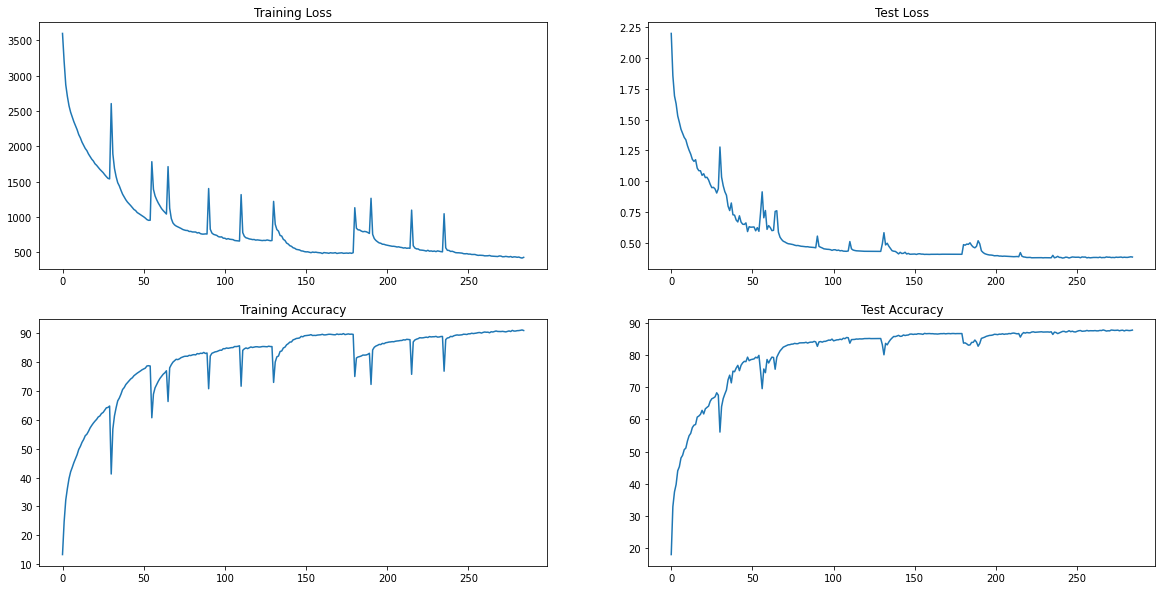

In [47]:
plot_graphs(train_losses=train_losses, train_accuracy=train_accuracy,
            test_losses=test_losses,test_accuracy=test_accuracy)